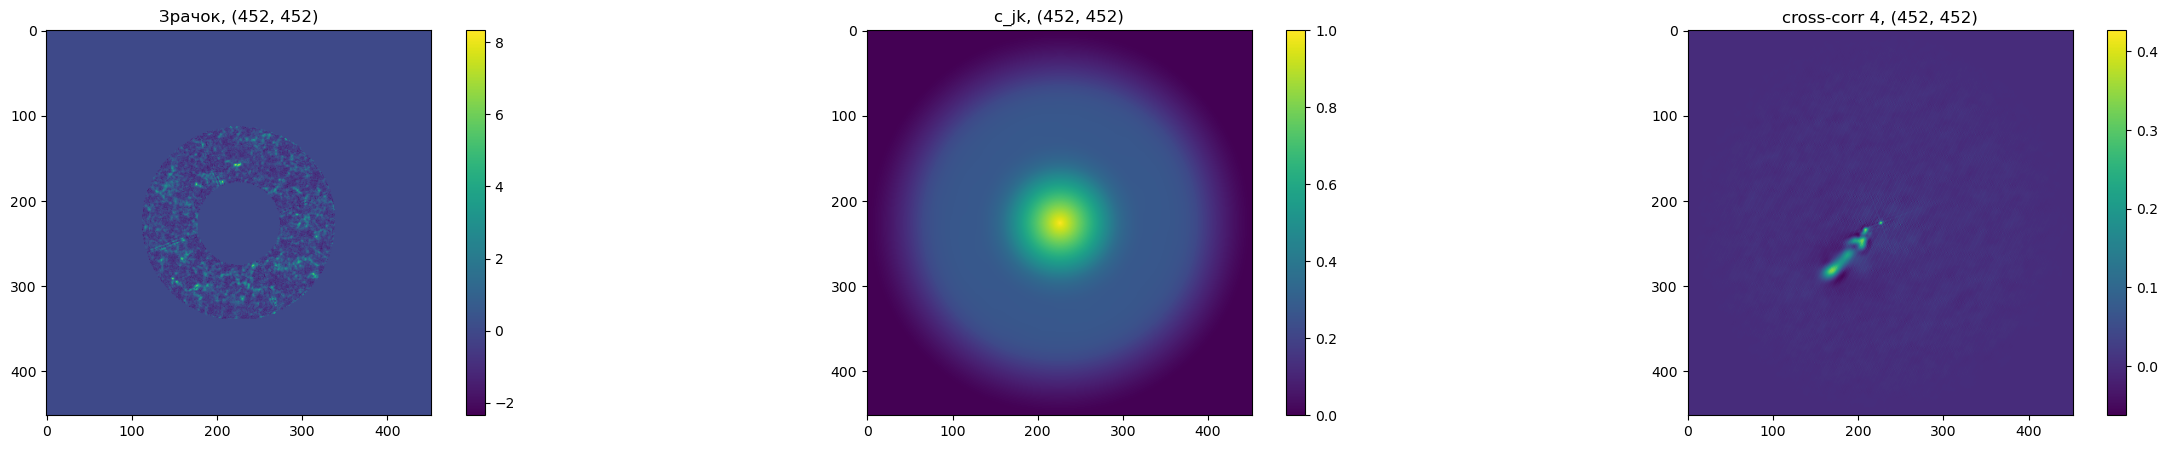

In [100]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, z):
    global cjk, t, a1, gammas, data, delta
      
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    res = shift(res, (-Ypix, Xpix), order=1)  
    res = res * cjk

    k = data[data.shape[0]//2-round(Ypix), data.shape[1]//2+round(Xpix)] \
        / res[res.shape[0]//2-round(Ypix), res.shape[1]//2+round(Xpix)]
    
    res = res * k
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'C:/astro/domecam'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

pupil = np.loadtxt(f'{data_dir}/frame.gz')
data = np.loadtxt(f'{data_dir}/data_corr4.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
gammas = np.load(f'{data_dir}/gammas.npy')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]//2) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    tmp = 0
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [0, 0, 2000]
            psf = multi_speckle_fit(myParams, ydata=res)
            print('-initial value:', res[my, mx])
            res -= psf*0.9
        else:
            myParams = [Vx, Vy, 15000+5000*np.sin(np.random.uniform(-np.pi, np.pi))]  
            psf = multi_speckle_fit(myParams, ydata=res)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        print('-residual value:', res[my, mx])
        print(' ')
    
        tmp+=1
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total iterations:', tmp)
    print('time:', time.perf_counter()-st)
    return comps, res, cl


def multi_speckle_fit(params, ydata=None):
    global data, t, delta, X, Y
    st=time.perf_counter()  
    def speckle_fit(params, ydata):
        xdata = np.vstack((X.ravel(), Y.ravel()))
        fit = np.zeros(X.shape)
        
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], *args).ravel()
            return arr
        
        ydata = ydata.ravel()
#         bounds = [[params[0]-3, params[1]-3, 2000], [params[0]+3, params[1]+3, 50000]]
        bounds = [[-np.inf, -np.inf, 2000], [np.inf, np.inf, 50000]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds) 
        
        fit += gamma_poly_se(X, Y, *popt)           
        return fit, popt[0], popt[1], popt[2]
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting:', *params)
    fit, Vx, Vy, z = speckle_fit(params, ydata)
    res +=fit
        
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {z}')
    print('time:', time.perf_counter()-st)    
    return res

def one_speckle_fit(params=None): 
    global data
    def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += gamma_poly_se(x, y, *args[i*3:i*3+3]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) # результирующее изображение
    xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
    ydata = data.ravel()
    
    lb = [-np.inf, -np.inf, 2000]
    lb = np.tile(lb, len(p0)//3)
    ub = [np.inf, np.inf, 40000]
    ub = np.tile(ub, len(p0)//3)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//3):
        fit += gamma_poly_se(X, Y, *popt[i*3:i*3+3])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//3):
        print(*popt[i*3:i*3+3])

    return fit, popt

[0.00518876 0.09885792]
0.0912114575621672
0.09120329469442368
otsu 1: 0.0912114575621672 otsu 2: 0.09226773288537515
max 1: 0.42669999599456787 max 2: 0.42669999599456787
min 1: -0.06267359852790833 min 2: -0.0529339499771595
mean 1: 0.0029639288282292293 mean 2: 0.002706172522313187


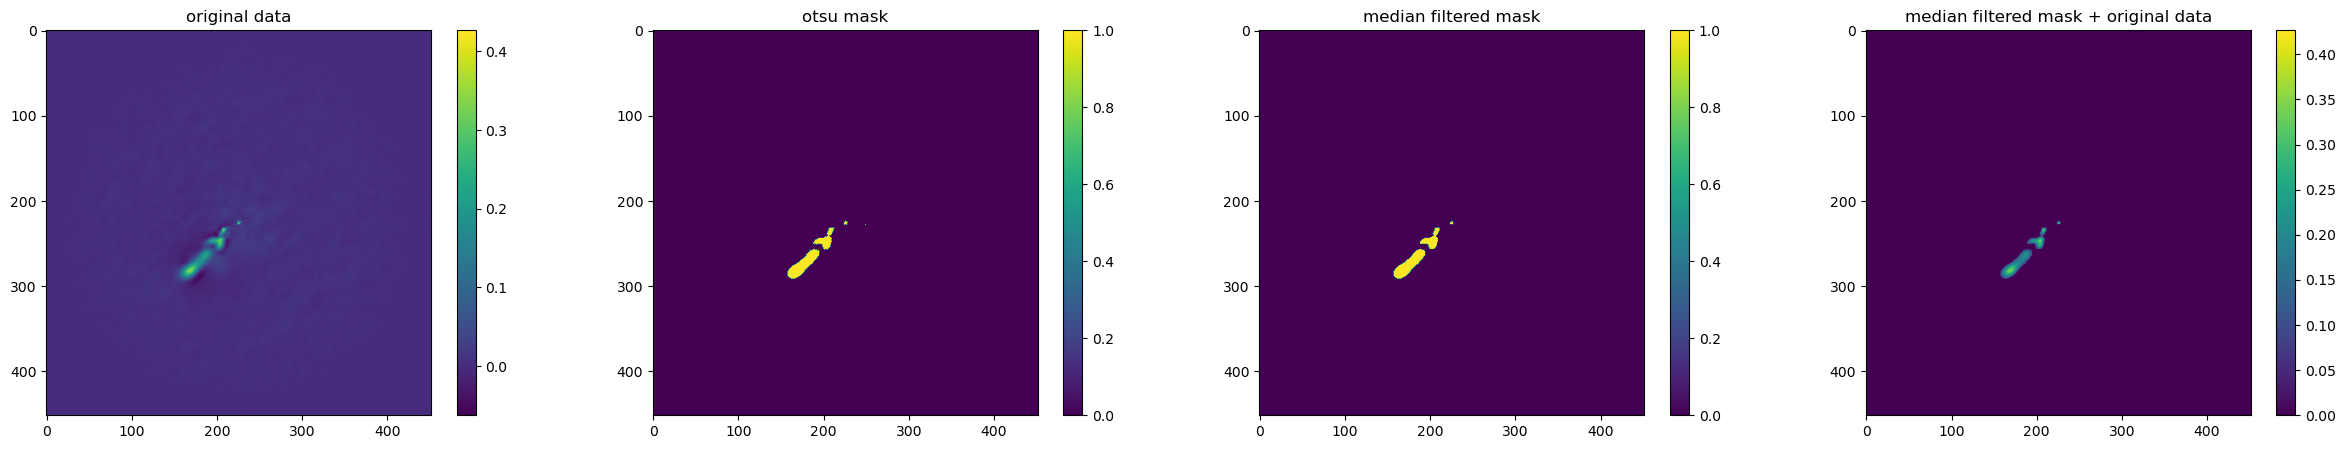

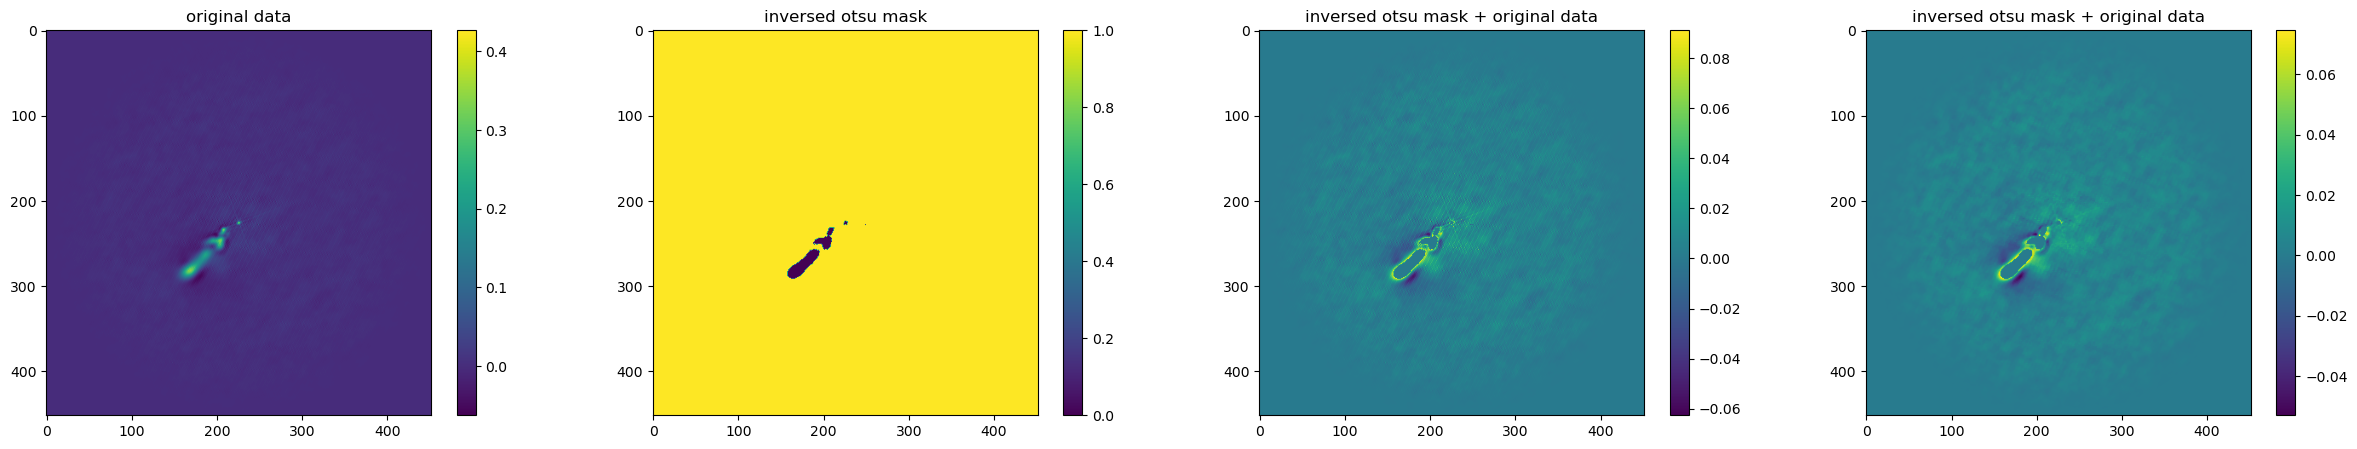

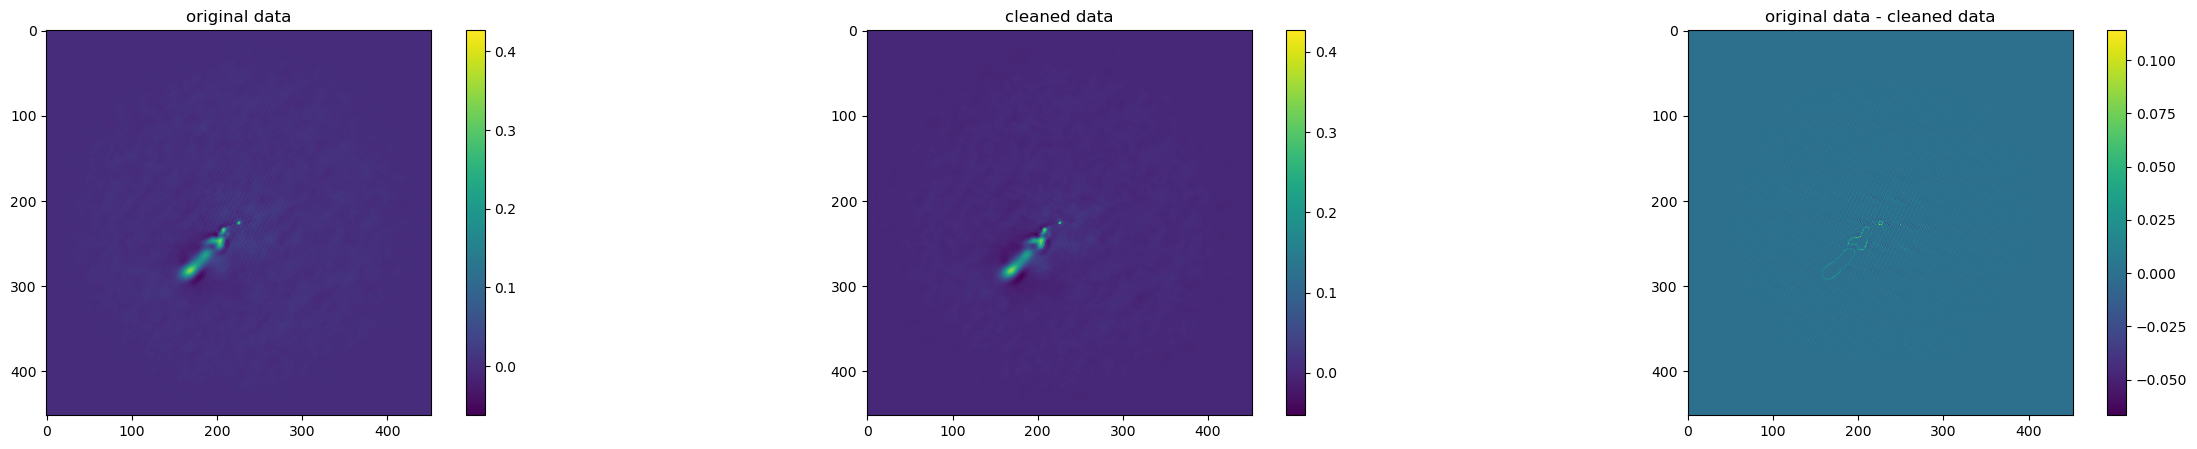

<Figure size 640x480 with 0 Axes>

In [104]:
from skimage.restoration import denoise_bilateral

mask = (data>threshold_otsu(data))*int(1)
med = median(mask)*int(1)
mask_inv = mask.copy()

mask_inv = ~mask_inv+2

new_image = median(mask_inv*data) + med*data 

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(data), ax = ax)
ax.set_title('original data')

fig.colorbar(ax2.imshow(mask), ax = ax2)
ax2.set_title('otsu mask')

fig.colorbar(ax3.imshow(med), ax = ax3)
ax3.set_title('median filtered mask')

fig.colorbar(ax4.imshow(med*data), ax = ax4)
ax4.set_title('median filtered mask + original data')

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(data), ax = ax)
ax.set_title('original data')

fig.colorbar(ax2.imshow(mask_inv), ax = ax2)
ax2.set_title('inversed otsu mask')

fig.colorbar(ax3.imshow(mask_inv*data), ax = ax3)
ax3.set_title('inversed otsu mask + original data')

fig.colorbar(ax4.imshow(median(mask_inv*data)), ax = ax4)
ax4.set_title('inversed otsu mask + original data')

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(data), ax = ax)
ax.set_title('original data')

fig.colorbar(ax2.imshow(new_image), ax = ax2)
ax2.set_title('cleaned data')

fig.colorbar(ax3.imshow(data - new_image), ax = ax3)
ax3.set_title('original data - cleaned data')

print(threshold_multiotsu(data))
print(threshold_otsu(data))
print(np.max(mask_inv*data))

print('otsu 1:', threshold_otsu(data), 'otsu 2:', threshold_otsu(new_image)) 
print('max 1:', np.max(data), 'max 2:', np.max(new_image))
print('min 1:', np.min(data), 'min 2:', np.min(new_image))
print('mean 1:', np.mean(data), 'mean 2:', np.mean(new_image))

plt.figure()
tst = np.digitize(data, bins=[0.00518876, 0.09185792])
data2 = tst == 2 
data0 = tst == 0

tst[np.where(tst==0)] = 2
tst -= 1
tst = ~tst+2
# tst2 = denoise_bilateral(tst*data, sigma_color=0.05, sigma_spatial=15)
# tst3 = tst2+data2*data+data0*data
# plt.imshow(tst3)
# plt.colorbar()


Speckle fitting: 0 0 2000
Fitted parametrs: 0.06 0.09 2000.0000000000002
time: 0.24621599999954924
-initial value: 0.42669999599456787
-residual value: 0.042669999599456776
 
Speckle fitting: -15.763274336283187 -15.486725663716813 12482.30969022354
Fitted parametrs: -15.84 -15.35 39807.96060998848
time: 0.564066200000525
-initial value: 0.3422932592861352
-residual value: 0.23952332117482994
 
Speckle fitting: -6.084070796460177 -6.084070796460177 19711.476162592044
Fitted parametrs: -6.50 -6.29 21182.37933399666
time: 0.39992009999969014
-initial value: 0.3306003698584835
-residual value: 0.24538039815595464
 
Speckle fitting: -4.977876106194691 -2.2123893805309733 17435.711621029724
Fitted parametrs: -5.03 -2.62 6175.013384943423
time: 0.709290100000544
-initial value: 0.3285478199748068
-residual value: 0.2523768190782012
 
Speckle fitting: -5.807522123893805 -5.530973451327434 10260.942458632413
Fitted parametrs: -6.50 -6.19 18022.435081055926
time: 0.5660107000003336
-initial val

Fitted parametrs: 8.92 25.03 4751.268730160149
time: 0.5685815000006187
-initial value: 0.10086059310713653
-residual value: 0.10085650058565292
 
Speckle fitting: -4.977876106194691 -1.9358407079646016 13609.809161915282
Fitted parametrs: -5.67 -0.97 4592.158344293208
time: 0.6546570999998949
-initial value: 0.10085650058565292
-residual value: 0.10169526875995347
 
Speckle fitting: -4.977876106194691 -1.9358407079646016 19667.108636266745
Fitted parametrs: -5.25 -4.15 3625.653487239033
time: 0.693256399999882
-initial value: 0.10169526875995347
-residual value: 0.10027290254103327
 
Speckle fitting: -4.977876106194691 -1.9358407079646016 18934.159037463894
Fitted parametrs: -37.75 -37.44 5504.712894844479
time: 0.9601163999996061
-initial value: 0.10027290254103327
-residual value: 0.10027940202771338
 
Speckle fitting: -4.977876106194691 -1.9358407079646016 10026.438849122354
Fitted parametrs: -4.98 -1.66 6727.527660960603
time: 0.6017646000000241
-initial value: 0.10027940202771338

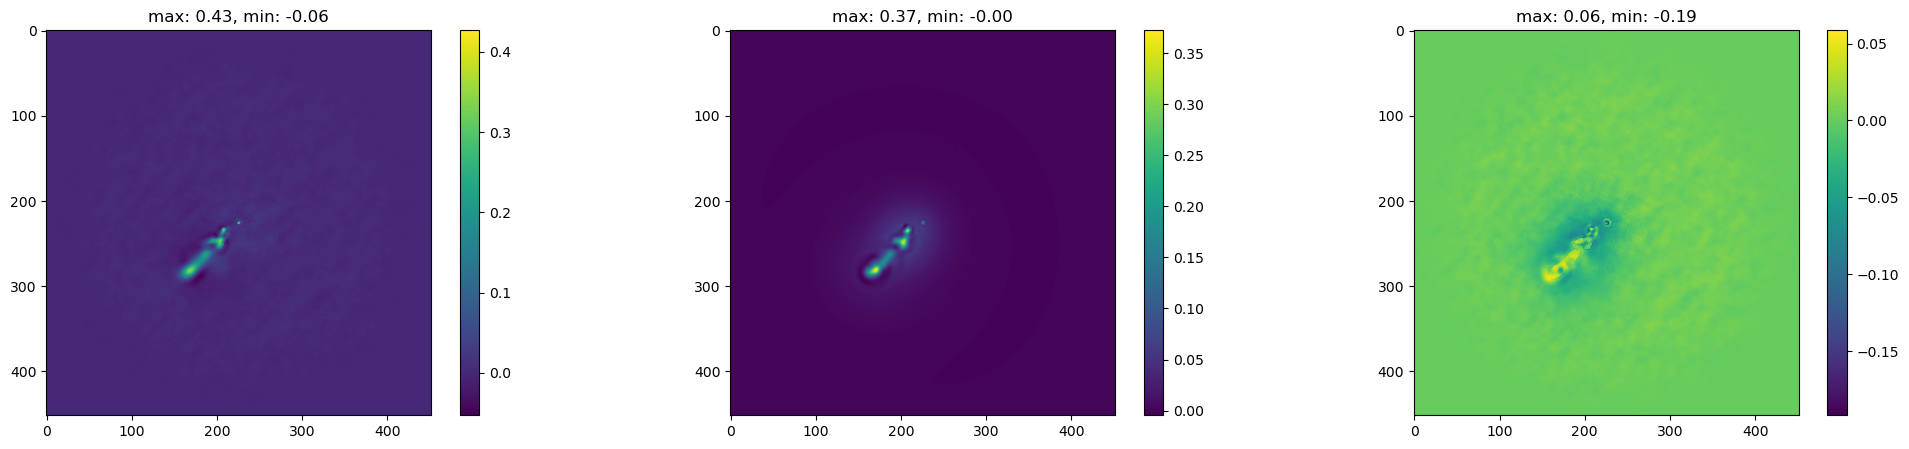

In [105]:
comps, residual, clean = CLEAN(new_image, gain=0.3, thresh=0.061, niter=100)
# CLEAN(data, gain=1, thresh=np.mean(data), niter=150) - неплохие настройки

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(new_image), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.2f}, min: {np.min(data):.2f}') 
ax2.set_title(f'max: {np.max(clean):.2f}, min: {np.min(clean):.2f}') 
ax3.set_title(f'max: {np.max(residual):.2f}, min: {np.min(residual):.2f}')
print('')

In [ ]:
myparams = np.stack((vx, vy, z))
myparams2=[]
for i in range(len(myparams[0])):
    myparams2.append((myparams[0][i], myparams[1][i], myparams[2][i]))


myparams2 = np.array(myparams2)
print(myparams2, '\nlen:', myparams2.shape, '\n')
myparams2 = np.unique(np.vectorize(round)(myparams2), axis=0)
myparams2 = myparams2[np.ndarray.argsort(myparams2[:, 2])]
print(myparams2, '\nlen:', myparams2.shape)

# a1 = np.logspace(0, 2, num=9, base=10)
# plt.plot(a1)

In [ ]:
fit, popt, Cn2v = one_speckle_fit(params=myparams2)
popt = np.round(popt, 2)
z=[]
vx=[]
vy=[]
for i in range(len(popt)//3):
    z.append(popt[3*i+2])
    vx.append(popt[3*i])
    vy.append(popt[3*i+1]) 

profile = np.stack((z, vx, vy))


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
cr = data.shape[0]//2 # центр изображения

fig.colorbar(ax.imshow(data), ax=ax)
ax.set_title('Исходные данные')
fig.colorbar(ax2.imshow(fit), ax=ax2)
ax2.set_title('Апроксимация')
fig.colorbar(ax3.imshow(data-fit), ax=ax3)
ax3.set_title('Разность')
ax3.scatter(np.unravel_index(np.argmin(data-fit), (data-fit).shape)[1], 
            np.unravel_index(np.argmin(data-fit), (data-fit).shape)[0], color='red', alpha=0.5, s=5, label='min')
ax3.scatter(np.unravel_index(np.argmax(data-fit), (data-fit).shape)[1],
            np.unravel_index(np.argmax(data-fit), (data-fit).shape)[0], color='purple', alpha=0.5, s=5, label='max')
ax3.legend()
fig.suptitle(f'All in, RMS = {np.mean((data - fit)**2)}', fontsize=14)

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(25, 5))

ax4.scatter(Cn2v, profile[0], color='red')
ax5.scatter(profile[1], profile[0], color='red')
ax6.scatter(profile[2], profile[0], color='red')
ax4.set_xlabel('Cn2')
ax4.set_ylabel('z')
ax5.set_xlabel('Vx')
ax5.set_ylabel('z')
ax6.set_xlabel('Vy')
ax6.set_ylabel('z')
ax4.grid(color = 'black', linestyle='--', alpha = 0.2)
ax5.grid(color = 'black', linestyle='--', alpha = 0.2)
ax6.grid(color = 'black', linestyle='--', alpha = 0.2)

print('min value fit:', np.min(data-fit), 'coords:', np.unravel_index(np.argmin(data-fit), (data-fit).shape))
print('max value fit:', np.max(data-fit), 'coords:', np.unravel_index(np.argmax(data-fit), (data-fit).shape))
print('centr value:', (data-fit)[226, 226])